# **Installing and importing dependencies**

In [ ]:
!pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow

In [ ]:
os.chdir('/content/drive/MyDrive/Signal')

Defining a function to plot the circles founded in the images.

In [ ]:
def plot_HoughCircles(circles, img, eps=5):
    mask = np.zeros_like(img)
    for circle in circles:
        x, y, R = circle

        for i in range(-R, R + 1):
            for j in range(-R, R + 1):
                if ((i ** 2 + j ** 2) > (R - eps // 2) ** 2) & ((i ** 2 + j ** 2) < (R + eps // 2) ** 2):
                    mask[np.clip(y + i, 0, img.shape[0] - 1),
                         np.clip(x + j, 0, img.shape[1] - 1)] = [0, 0, 255]

    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(np.maximum(img, mask), cv2.COLOR_BGR2RGB) , cmap = 'gray')

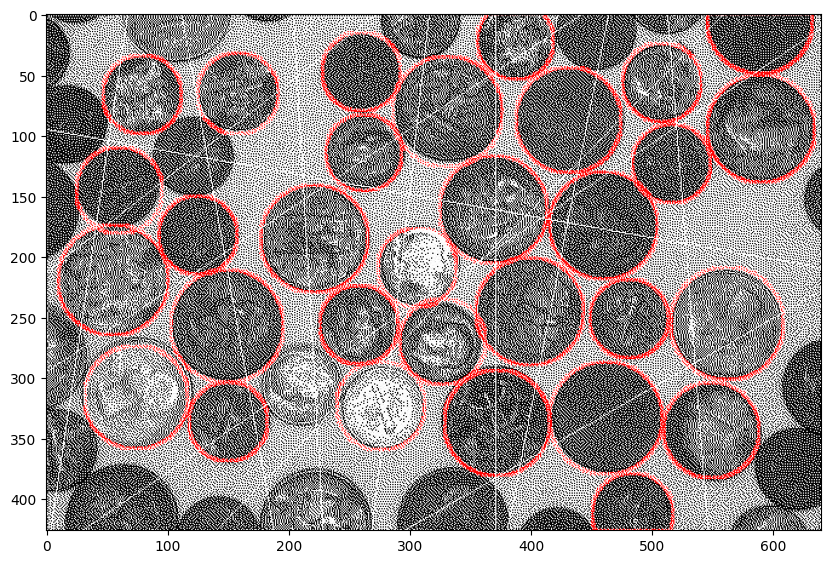

In [ ]:
### Example

coins = cv2.imread('coin_data/coins_noize_1.jpg')
gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 2)


circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 10,
                               param1=100, param2=30,
                               minRadius=25, maxRadius=50)

coins_setected = len(circles[0])
plot_HoughCircles(circles[0].astype(int), coins)

Crop the images using the circles founded using the algorithm.

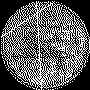

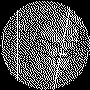

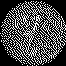

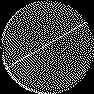

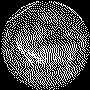

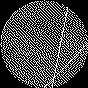

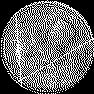

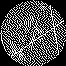

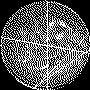

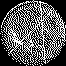

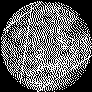

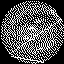

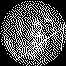

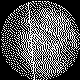

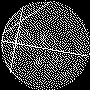

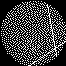

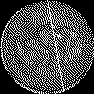

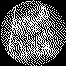

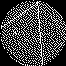

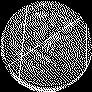

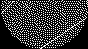

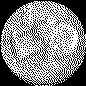

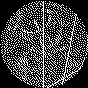

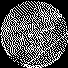

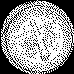

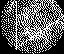

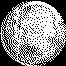

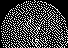

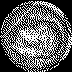

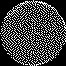

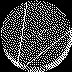

In [ ]:
for (x, y, r) in circles[0]:
        mask = np.zeros_like(gray) #Create a mask of the same dimension as the original


        center = (int(x), int(y))
        radius = int(r) #Identify center and radius of the circle
        cv2.circle(mask, center, radius, (255, 255, 255), -1) #White circle


        masked_data = cv2.bitwise_and(gray, gray, mask=mask) # Apply the mask

        # Cut the coin
        x1 = max(0, center[0] - radius)
        y1 = max(0, center[1] - radius)
        x2 = min(coins.shape[1], center[0] + radius)
        y2 = min(coins.shape[0], center[1] + radius)
        cropped_coin = masked_data[y1:y2, x1:x2]


        cv2_imshow(cropped_coin)

In [ ]:
# Quality of number of found images
data = pd.read_csv("coin_data/coins_count_values.csv") # Data with coins and their numbers in the images
data['folder'].unique()

data_euro = data[data['folder'] =='euro_coins'] #Consider only euro coins


error = []
for index, row in data_euro.iterrows():
    name = row['image_name'] # Name of the image
    real_num = row['coins_count'] # Number of coins in the image

    coins = cv2.imread(f"coin_data/euro_coins/{name}") # Read image
    gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY) # Convert image to gray
    blur = cv2.GaussianBlur(gray, (9,9), 2) # Add gaussian filter to reduce noise




    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 10, # Identify circles in the image
                                param1=100, param2=30,
                                minRadius=25, maxRadius=50)
    try:
        coins_setected = len(circles[0])
    except:
        coins_setected = 0

    error.append(coins_setected - real_num) # Difference between coins detected by the algorithm and real number of coins in the photo


np.mean(np.abs(error))

3.2337662337662336

In [ ]:
#Trying to find right parameters

def coin_finder(param1 = 100,param2=30, minRadius=25, maxRadius=50):
    error = []
    for index, row in data_euro.iterrows():
        name = row['image_name']
        real_num = row['coins_count']

        coins = cv2.imread(f"coin_data/euro_coins/{name}")
        gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (9,9), 2)




        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 10,
                                    param1=param1, param2=param2,
                                    minRadius=minRadius, maxRadius=maxRadius)
        try:
            coins_setected = len(circles[0])
        except:
            coins_setected = 0

        error.append(coins_setected - real_num)

    return np.mean(np.abs(error))

In [ ]:
def objective(trial):
    # Suggest values for the hyperparameters
    param1 = trial.suggest_int('param1', 20, 150)
    param2 = trial.suggest_int('param2', 10, 50)
    minRadius = trial.suggest_int('minRadius', 50, 150)
    maxRadius = trial.suggest_int('maxRadius', 0, 60)

    if maxRadius <= minRadius:
        raise optuna.exceptions.TrialPruned()

    # Compute the value of the custom function
    return coin_finder(param1, param2, minRadius, maxRadius)

In [ ]:
# Create a study object
study = optuna.create_study(direction='minimize')

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best parameters and value
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)


study.best_params

[I 2024-06-16 14:33:40,831] A new study created in memory with name: no-name-c4195ce0-7669-498a-af4e-eb4db27632c1
[I 2024-06-16 14:33:45,905] Trial 0 finished with value: 5.7186147186147185 and parameters: {'param1': 85, 'param2': 38, 'minRadius': 123, 'maxRadius': 45}. Best is trial 0 with value: 5.7186147186147185.
[I 2024-06-16 14:33:51,831] Trial 1 finished with value: 5.1688311688311686 and parameters: {'param1': 49, 'param2': 16, 'minRadius': 71, 'maxRadius': 50}. Best is trial 1 with value: 5.1688311688311686.
[I 2024-06-16 14:33:56,886] Trial 2 finished with value: 5.064935064935065 and parameters: {'param1': 46, 'param2': 19, 'minRadius': 71, 'maxRadius': 9}. Best is trial 2 with value: 5.064935064935065.
[I 2024-06-16 14:34:01,080] Trial 3 finished with value: 5.774891774891775 and parameters: {'param1': 132, 'param2': 39, 'minRadius': 138, 'maxRadius': 35}. Best is trial 2 with value: 5.064935064935065.
[I 2024-06-16 14:34:06,538] Trial 4 finished with value: 5.7445887445887

In [ ]:
##Check with best parameters
error = []
for index, row in data_euro.iterrows():
    name = row['image_name']
    real_num = row['coins_count']

    coins = cv2.imread(f"coin_data/euro_coins/{name}")
    gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 2)




    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 10,
                                param1=99, param2=40,
                                minRadius=14, maxRadius=53)
    try:
        coins_setected = len(circles[0])
    except:
        coins_setected = 0

    try:
       for (x, y, r) in circles[0]:
        mask = np.zeros_like(gray)


        center = (int(x), int(y))
        radius = int(r)
        cv2.circle(mask, center, radius, (255, 255, 255), -1)


        masked_data = cv2.bitwise_and(coins, coins, mask=mask)


        x1 = max(0, center[0] - radius)
        y1 = max(0, center[1] - radius)
        x2 = min(coins.shape[1], center[0] + radius)
        y2 = min(coins.shape[0], center[1] + radius)
        cropped_coin = masked_data[y1:y2, x1:x2]

        if index < 20:
          cv2_imshow(cropped_coin)
    except:
        continue

    error.append(coins_setected - real_num)


np.mean(np.abs(error))

2.4415584415584415

We can see that most of the coins are not well detected by the algorithm. In some cases, the algorithm identifies pretty well the coin (a recurring pattern seems to be that when the background is white, the algorithm performs well), while in some other cases, it does not even identifies circles or identifies circles within the coin.

We try to build a classification model, trying to predict the value of the coin from the image.

## **Model**

Download the data from Kaggle.
Data consists of collection of 211 different classes from 32 currencies; however we will consider only the euro classes. So, we will have:
* **Train data** with 224 images divided in 8 classes (1 cent, 2 cent...) used for the training of the classifier
* **Test data** with 32 images divided in 8 classes (1 cent, 2 cent...) used for the testing of the classifier
* **Validation data** with 32 images divided in 8 classes (1 cent, 2 cent...) used for the testing of the classifier. These images will be merged with the train data since we do not have a validation process

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [ ]:
!kaggle datasets download -d wanderdust/coin-images # Download data from Kaggle

Dataset URL: https://www.kaggle.com/datasets/wanderdust/coin-images
License(s): other
 99% 453M/459M [00:06<00:00, 60.5MB/s]
100% 459M/459M [00:06<00:00, 71.4MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

**CLASSES**

* "54" --> 1 euro Cent
* "55" --> 2 euro Cent
* "56" --> 5 euro Cent
* "57" --> 10 euro Cent
* "58" --> 20 euro Cent
* "59" --> 50 euro Cent
* "60" --> 1 Euro
* "61" --> 2 Euro


Code for removing all the classes we are not interested in from the data.

In [ ]:
interested_classes = ['54', '55', '56', '57', '58', '59', '60','61'] # Considering only the classes of the euro coins


source_folder = 'coins/data'
target_folder = '/content/filtered_data'


os.makedirs(target_folder, exist_ok=True)


def copy_interested_classes(split):
    split_source_folder = os.path.join(source_folder, split)
    split_target_folder = os.path.join(target_folder, split)

    if not os.path.exists(split_source_folder):
        print(f"{split_source_folder} does not exist")
        return

    os.makedirs(split_target_folder, exist_ok=True)

    for class_name in interested_classes:
        class_source_folder = os.path.join(split_source_folder, class_name)
        class_target_folder = os.path.join(split_target_folder, class_name)

        if os.path.exists(class_source_folder):
            shutil.copytree(class_source_folder, class_target_folder)
        else:
            print(f"Class folder {class_source_folder} does not exist")


for split in ['train', 'validation', 'test']:
    copy_interested_classes(split)

Build the dataset for the training and testing of the classifier.

In [ ]:
def load_images(folder, size=(64, 64)):
    images = [] # List of images
    labels = [] # List of labels
    class_names = os.listdir(folder) # List of class names

    for class_name in class_names:
        class_folder = os.path.join(folder, class_name) # Consider a folder
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder): # Iterate on the images in the folder
                img_path = os.path.join(class_folder, filename)
                coins = cv2.imread(img_path) # Read the image
                gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY) # Convert to gray
                blur = cv2.GaussianBlur(gray, (9,9), 2) # Blur the image with a gaussian filter
                circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 10, # Identify circles
                                param1=99, param2=40,
                                minRadius=14, maxRadius=53)
                try: # If the algorithm detects circles
                  for (x, y, r) in circles[0]:

                    # Cut the detected circle
                    mask = np.zeros_like(gray)


                    center = (int(x), int(y))
                    radius = int(r)
                    cv2.circle(mask, center, radius, (255, 255, 255), -1)


                    masked_data = cv2.bitwise_and(gray, gray, mask=mask)

                    x1 = max(0, center[0] - radius)
                    y1 = max(0, center[1] - radius)
                    x2 = min(coins.shape[1], center[0] + radius)
                    y2 = min(coins.shape[0], center[1] + radius)
                    cropped_coin = masked_data[y1:y2, x1:x2]
                    cropped_coin = cv2.resize(cropped_coin, size) # Resize the image
                    cv2_imshow(cropped_coin)
                    coin_flatten = cropped_coin.flatten()

                    # Append the cutted coin to the list of images and the corresponding label
                    images.append(coin_flatten)
                    labels.append(class_name)
                except: # If the algorithm does not detect circles

                  # Do nothing and just append the image of the coin converted to gray with the corresponding label
                  img = cv2.resize(gray, size)
                  cv2_imshow(img)
                  coin_flatten = img.flatten()
                  images.append(coin_flatten)
                  labels.append(class_name)



    return np.array(images), np.array(labels)

In [ ]:
X_train, y_train = load_images('/content/filtered_data/train') # Create the train data
X_val, y_val = load_images('/content/filtered_data/validation') # Create the validation data
X_test, y_test = load_images('/content/filtered_data/test') # Create the test data

# Merge train and validation data
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)


# Standardization
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

Let us consider a KNN Classifier as classification model.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6) # Knn classifier

knn.fit(X_train, y_train) # Train the model

KNeighborsClassifier(n_neighbors=6)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          54       0.33      0.50      0.40         4
          55       0.00      0.00      0.00         4
          56       0.17      0.25      0.20         4
          57       0.33      0.25      0.29         4
          58       0.40      0.50      0.44         4
          59       0.50      0.25      0.33         4
          60       0.00      0.00      0.00         4
          61       0.00      0.00      0.00         4

    accuracy                           0.22        32
   macro avg       0.22      0.22      0.21        32
weighted avg       0.22      0.22      0.21        32



The model never predict some types of coins. Overally, it has an accuracy of 0.2 and we could try to improve the model with a better algorithm for coin detection and a better model.

## Xgboost

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder



In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [ ]:
xgb_model = xgb.XGBClassifier()


In [ ]:
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb)

In [ ]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

          54       0.25      0.25      0.25         4
          55       0.00      0.00      0.00         4
          56       0.00      0.00      0.00         4
          57       1.00      0.75      0.86         4
          58       0.50      0.50      0.50         4
          59       0.25      0.25      0.25         4
          60       0.25      0.25      0.25         4
          61       0.14      0.25      0.18         4

    accuracy                           0.28        32
   macro avg       0.30      0.28      0.29        32
weighted avg       0.30      0.28      0.29        32

